# Trying to Fix Curve

This one isn't going to be tutorial styled or anything like that. My previous curve sucks big time and I will try to fix it directly in any piece of code below.

## Init

In [35]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

In [36]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(13, 8))  
plt.rc('lines', linewidth=2)  

In [37]:
np.random.seed(42)

## Utility Functions

In [38]:
import math
def check_finite_many(retT):
    not_finite = []
    for i in range(0, len(retT)):
        if not np.isfinite(retT[i]).all():
            not_finite.append(i)
    
    if len(not_finite) > 0:
        raise Exception("Not finite: " + str(not_finite))
        
def check_finite(retT):
    not_finite = []
    for i in range(0, len(retT)):
        if not math.isfinite(retT[i]):
            not_finite.append(i)
    
    if len(not_finite) > 0:
        raise Exception("Not finite: " + str(not_finite))

In [39]:
def map_function(t, f):
    return np.array([f(ti) for ti in t])

from operator import add
def sum_element(a, b):
    return np.array(list(map(add, a, b)))
def delta(arr):
    return np.array([arr[0]] + [arr[i]-arr[i-1] for i in range(1, len(arr))])

def plot_single(t, f, label):
    fig, ax = plt.subplots(1, 1)
    ax.plot(t, map_function(t, f), 'b', alpha=0.7, label=label)

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
              fancybox=True, shadow=True, ncol=7)
    
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
        
    plt.show()

## Model

In [40]:
def dpseicrd_rl_ext(y, t, population, 
                exposed_rate_normal, exposed_rate_critical, infectious_rate, 
                critical_rate, critical_chance, 
                recovery_rate_normal, recovery_rate_critical, 
                critical_limit, 
                death_rate_normal, death_chance_normal, 
                death_rate_over, death_chance_over):
    
    population, susceptible, exposed_normal, exposed_over, infectious, critical_cared, critical_over, recovered, dead_normal, dead_over = y
    
    
    exposed_flow_normal = exposed_rate_normal(t) * susceptible * infectious / population
    exposed_flow_over = exposed_rate_critical * susceptible * critical_over / population
    
    infectious_flow_normal = infectious_rate * exposed_normal * 1
    infectious_flow_over = infectious_rate * exposed_over * 1
    
    recovery_flow_normal = recovery_rate_normal * infectious * (1-critical_chance)
    recovery_flow_critical = recovery_rate_critical * critical_cared * (1-death_chance_normal)
    
    death_flow_normal = death_rate_normal * critical_cared * death_chance_normal
    death_flow_over = death_rate_over * critical_over * death_chance_over
    
    #tricky part because it should be immediate
    
    #recovering or dying people will free up available care
    available_care = critical_limit(t) - critical_cared + recovery_flow_critical + death_flow_normal
    if available_care < 0:
        raise Exception("available_care should never be negative")
    
    #overflow applying for hospital should take precedence
    #well it's not like it will matter in numbers since new critical people will take their place here
    
    critical_over_return = 1 * min(available_care, critical_over) * 1
    
    available_care_2 = available_care - critical_over_return
    if available_care_2 < 0:
        raise Exception("available_care_2 should never be negative")
    
    #next, the new criticals will flow in
    
    critical_flow = critical_rate * infectious * critical_chance
    critical_flow_cared = min(available_care_2, critical_flow)
    
    available_care_3 = available_care_2 - critical_flow_cared
    if available_care_3 < 0:
        raise Exception("available_care_3 should never be negative")
    
    #the remains of that flow will go to over compartment
    critical_flow_over = critical_flow - critical_flow_cared
    
    dSdt = -exposed_flow_normal - exposed_flow_over
    dENdt = exposed_flow_normal - infectious_flow_normal
    dEOdt = exposed_flow_over - infectious_flow_over
    dIdt = infectious_flow_normal + infectious_flow_over - recovery_flow_normal - critical_flow_cared - critical_flow_over
    dCCdt = critical_flow_cared + critical_over_return - recovery_flow_critical - death_flow_normal
    dCOdt = critical_flow_over - death_flow_over - critical_over_return
    dRdt = recovery_flow_normal + recovery_flow_critical
    dDNdt = death_flow_normal
    dDOdt = death_flow_over
    dPdt = dSdt + dENdt + dEOdt + dIdt + dCCdt + dCOdt + dRdt + dDNdt + dDOdt
    
    return dPdt, dSdt, dENdt, dEOdt, dIdt, dCCdt, dCOdt, dRdt, dDNdt, dDOdt

In [41]:
def Model(days, population, critical_limit_data, critical_chance, death_chance_normal, death_time_over, exposed_rate_critical, r0_0, r0_L, L_start, L_end, k):
    check_finite((days, population, critical_chance, death_chance_normal, death_time_over, exposed_rate_critical, r0_0, r0_L, L_start, L_end, k))
    check_finite_many(critical_limit_data)
    
    # this is derived parameter
    infectious_period_opt = recovery_time_normal * (1-critical_chance) + critical_time * critical_chance #this is derived parameter
    infectious_rate = 1.0 / incubation_period # this is derived parameter
    recovery_rate_normal = 1.0 / recovery_time_normal # this is derived parameter
    death_rate_normal = 1.0 / death_time_normal # this is derived parameter
    critical_rate = 1.0 / critical_time # this is derived parameter
    recovery_rate_critical = 1.0 / recovery_time_critical #this is derived parameter
    death_rate_over = 1.0/death_time_over # this is a derived parameter
    r0_delta = r0_0 - r0_L # this is derived parameter

    check_finite((infectious_period_opt, infectious_rate, recovery_rate_normal, death_rate_normal, critical_rate, recovery_rate_critical, death_rate_over, r0_delta))
    
    def logistic_r0(t):
        e1 = np.exp(-k*(-t+L_start))
        e2 = np.exp(k*(-t+L_end))
        
        r0 = r0_L + r0_delta / (1 + e1) + r0_delta / (1 + e2)
        '''
        try:
            check_finite((e1, e2, r0))
        except Exception as ex:
            raise Exception(str(ex) + "\nArgs(t, k, r0_L, r0_delta, L_start, L_end, e1, e2, r0)=" + str((t, k, r0_L, r0_delta, L_start, L_end, e1, e2, r0)))
        '''
        return r0

    def exposed_rate_logistic(t):
        ret = logistic_r0(t) / infectious_period_opt
        check_finite((ret,))
        return ret
    
    def critical_limit(t):
        smallest_day = -1
        ret = float("inf")
        #ret = 1000
        for day, limit in critical_limit_data:
            if smallest_day < day and day <= t:
                smallest_day = day
                ret = limit
            else:
                break
        check_finite((ret,))
        return ret
    
    def r0_over(critical_over):
        return exposed_rate_critical * death_time_over * critical_chance * (critical_over/population)

    population_init, susceptible_init, exposed_normal_init, exposed_over_init, infectious_init, critical_cared_init, critical_over_init, recovered_init, dead_normal_init, dead_over_init = population, population-1, 1, 0, 0, 0, 0, 0, 0, 0  # initial conditions: one exposed, rest susceptible
    
    t = np.linspace(0, days-1, days) # days
    y0 = population_init, susceptible_init, exposed_normal_init, exposed_over_init, infectious_init, critical_cared_init, critical_over_init, recovered_init, dead_normal_init, dead_over_init # Initial conditions tuple

    check_finite(y0)
    
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(dpseicrd_rl_ext, y0, t, args=(
        population, exposed_rate_logistic, exposed_rate_critical, infectious_rate, 
        critical_rate, critical_chance, 
        recovery_rate_normal, recovery_rate_critical, 
        critical_limit, 
        death_rate_normal, death_chance_normal,
        death_rate_over, death_chance_over
    ))
    retT = ret.T
    population_2, susceptible, exposed_normal, exposed_over, infectious,  critical_cared, critical_over, recovered,  dead_normal, dead_over = retT
    
    check_finite_many(retT)
    
    critical_limit_val = map_function(t, critical_limit)
    #critical_limit_val = np.zeros(days)
    
    exposed = sum_element(exposed_normal, exposed_over)
    dead = sum_element(dead_normal, dead_over)
    death_chance_val = [0] + [100 * dead[i] / sum(infectious_rate*exposed[:i]) if sum(infectious_rate*exposed[:i])>0 else 0 for i in range(1, len(t))]
    #death_chance_val = np.zeros(days)
    
    r0_normal_val = map_function(t, logistic_r0)
    r0_over_val = map_function(critical_over, r0_over)
    #r0_normal_val = np.zeros(days)
    #r0_over_val = np.zeros(days)
    
    return t, population_2, susceptible, exposed_normal, exposed_over, infectious, critical_cared, critical_over, recovered,dead_normal, dead_over, critical_limit_val, death_chance_val, r0_normal_val, r0_over_val

## Plotter

In [42]:
def plot_pseicrd_l_ext2(t, population, 
                       susceptible, exposed_normal, exposed_over, infectious, 
                       critical_cared, critical_over, recovered, 
                       dead_normal, dead_over, critical_limit, death_chance, r0_normal, r0_over):
    fig, ax = plt.subplots(1, 1)
    
    #totals
    exposed = sum_element(exposed_normal, exposed_over)
    critical = sum_element(critical_cared, critical_over)
    dead = sum_element(dead_normal, dead_over)
    
    
    #main plot
    
    ax.plot(t, susceptible, 'b', alpha=0.7, label='Susceptible')
    ax.plot(t, exposed, 'y', alpha=0.7, label='Exposed')
    ax.plot(t, infectious, 'r', alpha=0.7, label='Infectious')
    ax.plot(t, critical, 'orange', alpha=0.7, label='Critical')
    ax.plot(t, recovered, 'g', alpha=0.7, label='Recovered')
    ax.plot(t, dead, 'black', alpha=0.7, label='Dead')
    ax.plot(t, population, 'grey', alpha=0.3, label='Population', ls='dotted')
    ax.plot(t, critical_limit, 'red', alpha=0.3, label='Healthcare', ls='dotted')
    
    ax.title.set_text('SEICRD')

    ax.set_xlabel('Time (days)', labelpad=10)

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax.legend(loc='best', shadow=True)
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # R0
    
    fig2, ax2 = plt.subplots(1, 1)
    ax2.plot(t, r0_normal, 'y', alpha=0.5, linewidth=2, label='R0 normal')
    ax2.plot(t, r0_over, 'r', alpha=0.5, linewidth=2, label='R0 over')
    r0_overall_val = sum_element(r0_normal, r0_over)
    ax2.plot(t, r0_overall_val, 'orange', alpha=0.7, linewidth=2, label='R0 overall')

    ax2.title.set_text('R0 over time')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend(loc='best', shadow=True)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax2.spines[spine].set_visible(False)
        
        
    # over cases only
    
    fig3, ax3 = plt.subplots(1, 1)
    ax3.plot(t, exposed_over, 'blue', alpha=0.7, linewidth=2, label='Exposed by Neglected')
    ax3.plot(t, critical_over, 'orange', alpha=0.7, linewidth=2, label="Critical but Neglected")
    ax3.plot(t, dead_over, 'black', alpha=0.7, linewidth=2, label='Dead by Neglect')

    ax3.title.set_text('Insufficient Healthcare')
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend(loc='best', shadow=True)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax3.spines[spine].set_visible(False)
    
    #death chance
    
    # sp2
    
    fig4, ax4 = plt.subplots(1, 1)
    ax4.plot(t, death_chance, 'blue', alpha=0.7, linewidth=2, label='Death Chance')

    ax4.title.set_text('Insufficient Healthcare')
    ax4.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax4.legend(loc='best', shadow=True)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax4.spines[spine].set_visible(False)
        
    #daily seicrd
    fig5, ax5 = plt.subplots(1, 1)
    
    daily_exposed = delta(exposed)
    daily_infectious = delta(infectious)
    daily_critical = delta(critical)
    daily_recovered = delta(recovered)
    daily_dead = delta(dead)
    
    ax5.plot(t, daily_exposed, 'y', alpha=0.7, label='Exposed')
    ax5.plot(t, daily_infectious, 'r', alpha=0.7, label='Infectious')
    ax5.plot(t, daily_critical, 'orange', alpha=0.7, label='Critical')
    ax5.plot(t, daily_recovered, 'g', alpha=0.7, label='Recovered')
    ax5.plot(t, daily_dead, 'black', alpha=0.7, label='Dead')
    ax5.plot(t, critical_limit, 'red', alpha=0.3, label='Healthcare', ls='dotted')
    
    ax5.title.set_text('Daily SEICRD')

    ax5.set_xlabel('Time (days)', labelpad=10)

    ax5.yaxis.set_tick_params(length=0)
    ax5.xaxis.set_tick_params(length=0)

    ax5.grid(b=True, which='major', c='w', lw=0.5, ls='-', alpha=0.25)

    ax5.legend(loc='best', shadow=True)
    
    for spine in ('top', 'right', 'bottom', 'left'):
        ax5.spines[spine].set_visible(False)
    
    
        
    # healthcare limit
    
    fig6, ax6 = plt.subplots(1, 1)
    ax6.plot(t, critical_cared, 'blue', alpha=0.7, linewidth=2, label='Critical cared')
    ax6.plot(t, critical_limit, 'orange', alpha=0.7, linewidth=2, label="Healthcare Limit")

    ax6.title.set_text('Healthcare limit')
    ax6.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax6.legend(loc='best', shadow=True)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax6.spines[spine].set_visible(False)
    
    plt.show()

## Data

In [43]:
beds = pd.read_csv("data/beds.csv", header=0)
agegroups = pd.read_csv("data/agegroups.csv")
probabilities = pd.read_csv("data/probabilities.csv")
covid_data = pd.read_csv("data/time_series_covid19_deaths_global_narrow.csv", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

In [44]:
# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

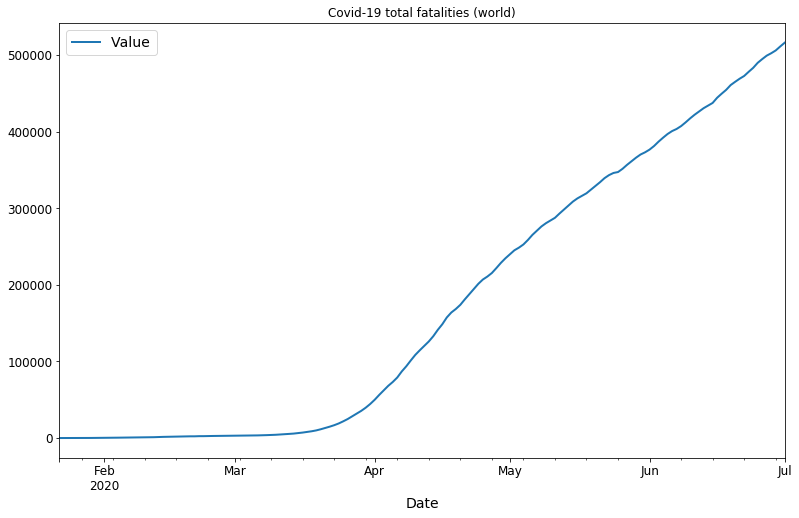

In [45]:
covid_data.groupby("Date").sum()[["Value"]].plot(title="Covid-19 total fatalities (world)")

## Curve Fitting

In [54]:
# sure thing 
death_chance_over = 1 # it's a sure thing

# this can be global
incubation_period = 3.0 # this can be global. shouldnt it be 14?
#death_chance_normal = 0.2 # this can be global

# this can be global, we dont have this but we got this from tutorial
critical_time = 12.0 # this can be global, we dont have this but we got this from tutorial

# this differs for each population, we dont have this but we got this from tutorial
recovery_time_normal = 9.0 # this differs for each population, we dont have this but we got this from tutorial
death_time_normal = 7.5 # this differs for each population, we dont have this but we got this from tutorial
recovery_time_critical = 6.5 # this differs for each population, we dont have this but we got this from tutorial

check_finite((death_chance_over, incubation_period, critical_time, recovery_time_normal, death_time_normal, recovery_time_critical))

In [55]:
# parameters
data = covid_data[covid_data["Location"] == "Italy"]["Value"].values[::-1]
critical_limit_data = [(0, beds_lookup["Italy"])]
outbreak_shift = 30
population = sum(agegroup_lookup["Italy"])
params_init_min_max = {
    "critical_chance": (0.05, 0.01, 0.1), 
    "death_chance_normal": (0.5, 0.05, 0.8),
    "death_time_over": (1.0, 1.0, 7.5),
    "exposed_rate_critical": (2.0, 1.0, 3.0), 
    "r0_0": (3.0, 2.0, 5.0), 
    "r0_L": (0.9, 0.0, 3.5),
    "L_start": (90, 0, 120), 
    "L_end": (120, 0, 500),
    "k": (2.5, 0.01, 5.0)
}  # form: {parameter: (initial guess, minimum value, max value)}

In [56]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, critical_chance, death_chance_normal, death_time_over, exposed_rate_critical, r0_0, r0_L, L_start, L_end, k):
    ret = Model(days, population, critical_limit_data, critical_chance, death_chance_normal, death_time_over, exposed_rate_critical, r0_0, r0_L, L_start, L_end, k)
    dead_normal = ret[9]
    dead_over = ret[10]
    dead = sum_element(dead_normal, dead_over)
    return dead[x]

In [57]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [58]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

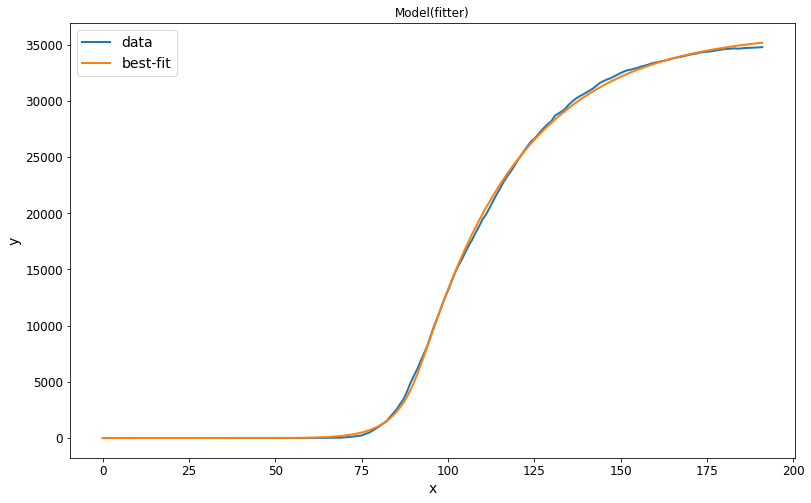

In [59]:
result.plot_fit(datafmt="-");

In [60]:
result

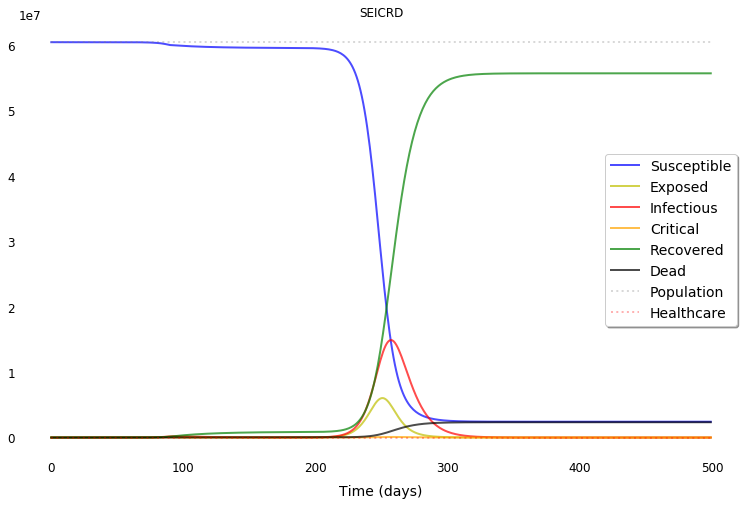

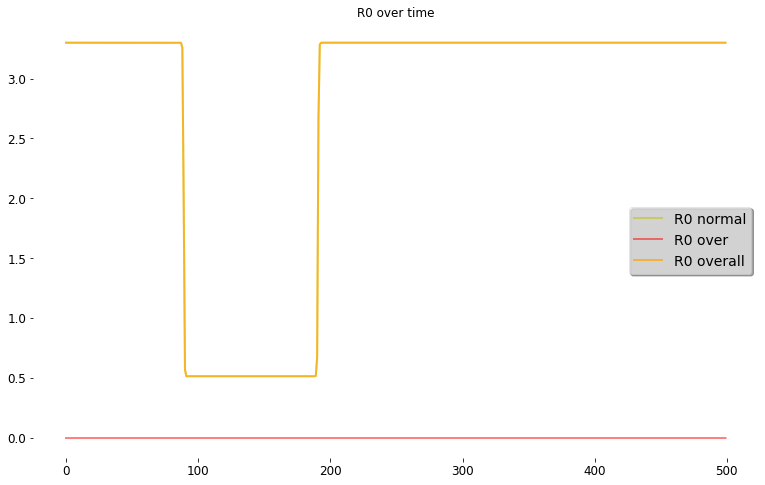

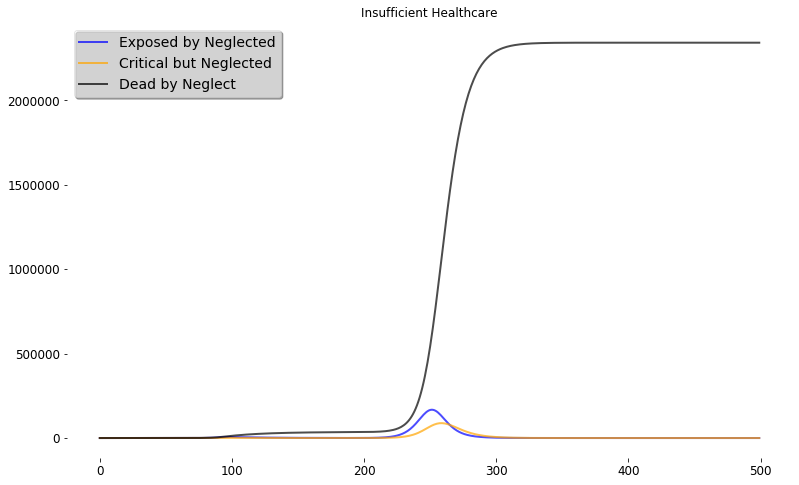

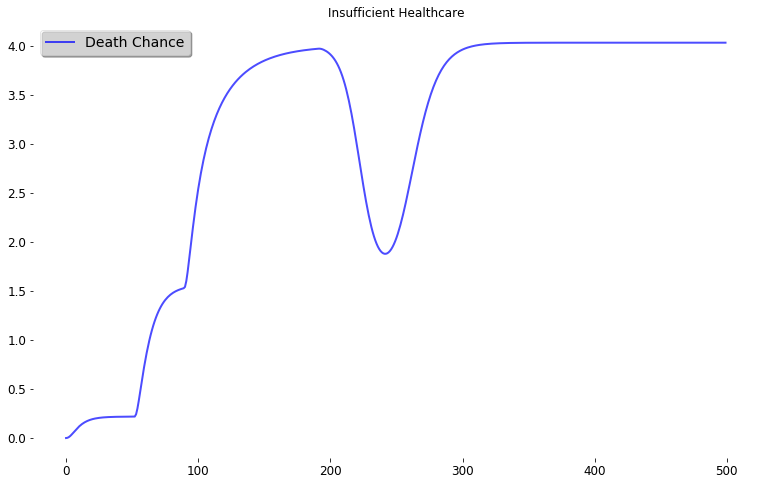

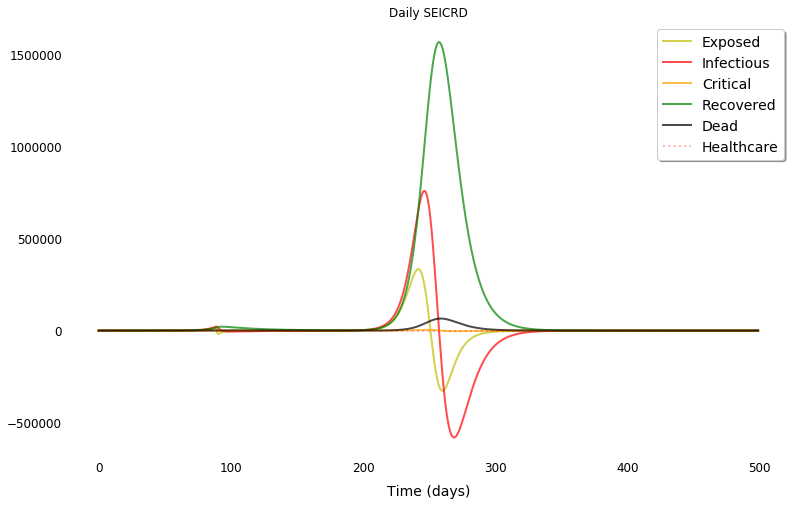

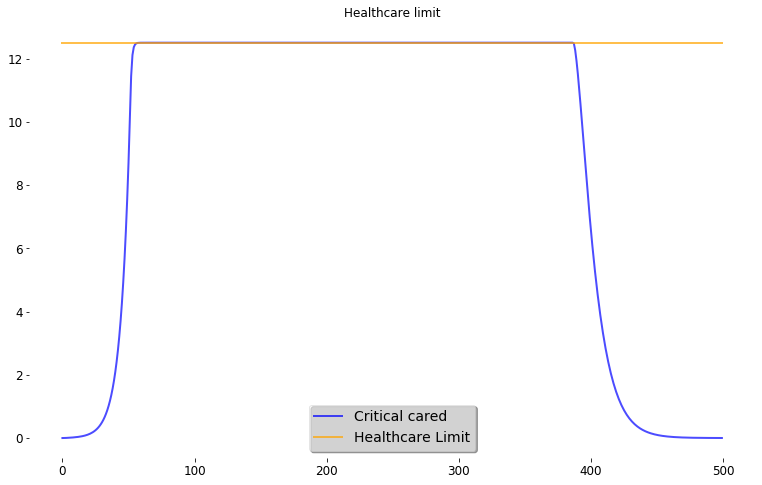

In [61]:
full_days = 500
plot_pseicrd_l_ext2(*Model(
    days=full_days, 
    population=population, 
    critical_limit_data=critical_limit_data, 
    **result.best_values
))